## Loading Data

In [63]:
import pandas as pd
from pathlib import Path

BASE_PATH = Path("../DATASETS/4")

post_file = BASE_PATH/'rspct_autos.tsv.gz'
subred_file = BASE_PATH/'subreddit_info.csv.gz'

In [64]:
post_df = pd.read_csv(post_file, sep = '\t')
subred_df = pd.read_csv(subred_file)

In [65]:
subred_df.set_index(['subreddit'], inplace=True)

In [66]:
df = post_df.join(subred_df, on = 'subreddit')

In [67]:
df.head(5)

,id,subreddit,title,selftext,category_1,category_2,category_3,in_data,reason_for_exclusion
0,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...,autos,harley davidson,NaN,True,NaN
1,5s0q8r,Mustang,Roush vs Shleby GT500,"I am trying to determine which is faster, and ...",autos,ford,NaN,True,NaN
2,5z3405,Volkswagen,2001 Golf Wagon looking for some insight,Hello! <lb><lb>Trying to find some information...,autos,VW,NaN,True,NaN
3,7df18v,Lexus,IS 250 Coolant Flush/Change,https://www.cars.com/articles/how-often-should...,autos,lexus,NaN,True,NaN
4,5tpve8,volt,Gen1 mpg w/ dead battery?,"Hi, new to this subreddit. I'm considering bu...",autos,chevrolet,NaN,True,NaN


#### Standardizing Attributes

In [68]:
print(df.columns)

Index(['id', 'subreddit', 'title', 'selftext', 'category_1', 'category_2',
       'category_3', 'in_data', 'reason_for_exclusion'],
      dtype='object')


In [69]:
column_mapping = {
 'id': 'id',
 'subreddit': 'subreddit',
 'title': 'title',
 'selftext': 'text',
 'category_1': 'category',
 'category_2': 'subcategory',
 'category_3': None, # no data
 'in_data': None, # not needed
 'reason_for_exclusion': None # not needed
}
# define remaining columns
columns = [c for c in column_mapping.keys() if column_mapping[c] != None]


In [70]:
df = df[columns].rename(columns = column_mapping)

In [71]:
df = df[df['category'] == 'autos']

In [72]:
df.sample(1).T

,12295
id,76ff08
subreddit,Volkswagen
title,Advice about 2006 Passat 2.0T?
text,"Hi everyone, I’m looking for a winter car and ..."
category,autos
subcategory,VW


In [73]:
import sqlite3

In [76]:
db_name = "reddit-selfposts.db"
con = sqlite3.connect(BASE_db_name)
df.to_sql("posts", con, index = False, if_exists = 'replace')
con.close()

In [77]:
con = sqlite3.connect(db_name)
df = pd.read_sql("select * from posts", con)
con.close()

## Cleaning Text

### Identify Noise with Regular Experssions

In [80]:
import re

In [81]:
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

In [89]:
def impurity(text, min_len = 0):
    '''returns the share of suspicious characters in a text'''
    len_text = len(text)
    if text == None or len_text < min_len:
        return 0
    return len(RE_SUSPICIOUS.findall(text)) / len_text

In [90]:
text = """
After viewing the [PINKIEPOOL Trailer](https://www.youtu.be/watch?v=ieHRoHUg)
it got me thinking about the best match ups.
<lb>Here's my take:<lb><lb>[](/sp)[](/ppseesyou) Deadpool<lb>[](/sp)[](/ajsly)
Captain America<lb>"""

impurity(text, 4)

0.09009009009009009

In [91]:
df['impurity'] = df['text'].apply(impurity, min_len = 10)

In [96]:
df[['text', 'impurity']].sort_values(by = 'impurity', ascending=False).head(5)

,text,impurity
19682,Looking at buying a 335i with 39k miles and 11...,0.214716
12357,I'm looking to lease an a4 premium plus automa...,0.165099
2730,Breakdown below:<lb><lb>Elantra GT<lb><lb>2.0L...,0.139130
12754,Bulbs Needed:<lb><lb><lb>**194 LED BULB x8**<l...,0.132411
10726,I currently have a deposit on a 2013 335is (CP...,0.129317


In [99]:
from exp import count_words

In [101]:
count_words(df, 
            column='text', 
            preprocess=lambda doc: re.findall(r'<[\w]*>', doc)
        )

,freq
token,
<lb>,100729
<tab>,642


### Removing Noise with Regular Expressions

In [103]:
import html

In [114]:
def clean(text):
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [115]:
clean_text = clean(text)
print(clean_text)
print("Impurity: ", impurity(clean_text))

After viewing the PINKIEPOOL Trailer it got me thinking about the best match ups. Here's my take: Deadpool Captain America
Impurity:  0.0


In [117]:
df['clean_text'] = df['text'].map(clean)
df['impurity'] = df['clean_text'].apply(impurity, min_len = 20)

df[['clean_text', 'impurity']].sort_values(by = 'impurity', ascending=False).head(3)

,clean_text,impurity
14058,"Mustang 2018, 2019, or 2020? Must Haves!! 1. H...",0.030864
18934,"At the dealership, they offered an option for ...",0.026455
16505,"I am looking at four Caymans, all are in a sim...",0.024631


### Character Normalization with textacy

In [118]:
text = "The café “Saint-Raphaël” is loca-\nted on Côte dʼAzur."

In [128]:
from textacy import preprocessing as tprep

In [137]:
def normalize(text):
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text

In [138]:
print(normalize(text))

The cafe "Saint-Raphael" is located on Cote d'Azur.


### Pattern-Based Data Masking with textacy

In [139]:
from textacy.preprocessing.resources import RE_URL

In [140]:
count_words(df, column='clean_text', preprocess=RE_URL.findall).head(4)

,freq
token,
www.getlowered.com,3
http://www.ecolamautomotive.com/#!2/kv7fq,2
https://www.reddit.com/r/Jeep/comments/4ux232/just_ordered_an_android_head_unit_joying_jeep/,2
http://imgur.com/gallery/XkRsw,2


In [153]:
from textacy.preprocessing.replace import urls
text = "Check out https://spacy.io/usage/spacy-101"
# using default substitution _URL_
print(urls(text))

Check out _URL_


In [154]:
df['clean_text'] = df['clean_text'].map(urls)
df['clean_text'] = df['clean_text'].map(normalize)

In [155]:
df.rename({'text': 'raw_text', 'clean_text': 'text'}, inplace = True)
df.drop(columns = ['impurity'], inplace=True)

In [156]:
con = sqlite3.connect(db_name)
df.to_sql('post_cleaned', con, index = False, if_exists='replace')
con.close()

## Tokenization

In [157]:
text = """
2019-08-10 23:32: @pete/@louis - I don't have a well-designed
solution for today's problem. The code of module AC68 should be -1.
Have to think a bit... #goodnight ;-) ᥌᥏"""

In [158]:
tokens = re.findall(r'\w\w+', text)
print(*tokens, sep='|')


2019|08|10|23|32|pete|louis|don|have|well|designed|solution|for|today|problem|The|code|of|module|AC68|should|be|Have|to|think|bit|goodnight|᥌᥏


In [159]:
RE_TOKEN = re.compile(r"""
 ( [#]?[@\w'’\.\-\:]*\w # words, hashtags and email addresses
 | [:;<]\-?[\)\(3] # coarse pattern for basic text emojis
 | [\U0001F100-\U0001FFFF] # coarse code range for unicode emojis
 )
 """, re.VERBOSE)

In [162]:
def tokenize(text): 
    return RE_TOKEN.findall(text)

tokens = tokenize(text)
print(*tokens, sep='|')

2019-08-10|23:32|@pete|@louis|I|don't|have|a|well-designed|solution|for|today's|problem|The|code|of|module|AC68|should|be|-1|Have|to|think|a|bit|#goodnight|;-)|᥌᥏


### Tokenizatino with NTLK

In [166]:
import nltk

In [167]:
token = nltk.tokenize.word_tokenize(text)

In [168]:
print(*token, sep = '|')

2019-08-10|23:32|:|@|pete/|@|louis|-|I|do|n't|have|a|well-designed|solution|for|today|'s|problem|.|The|code|of|module|AC68|should|be|-1|.|Have|to|think|a|bit|...|#|goodnight|;|-|)|᥌᥏


## Linguistic Processing with SpaCY

In [170]:
import spacy

In [171]:
nlp = spacy.load("en_core_web_sm")

In [172]:
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x21d2daad0a0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x21d2daad4c0>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x21d2d7489e0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x21d2db16080>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x21d2db33f80>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x21d2d748200>)]

In [173]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

### Processing Text

In [181]:
nlp = spacy.load("en_core_web_sm")
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

In [184]:
print(*doc, sep = '|')

My|best|friend|Ryan|Peters|likes|fancy|adventure|games|.


In [202]:
def display_nlp(doc, include_punct=False):
    """Generate data frame for visualization of spaCy tokens."""
    rows = []
    for i, t in enumerate(doc):
        if not t.is_punct or include_punct:
            row = {'token': i, 'text': t.text, 'lemma_': t.lemma_,
                 'is_stop': t.is_stop, 'is_alpha': t.is_alpha,
                 'pos_': t.pos_, 'dep_': t.dep_,
                 'ent_type_': t.ent_type_, 'ent_iob_': t.ent_iob_}
            rows.append(row)
    df = pd.DataFrame(rows).set_index('token')
    df.index.name = None
    return df


In [203]:
display_nlp(doc)

,text,lemma_,is_stop,is_alpha,pos_,dep_,ent_type_,ent_iob_
0,My,my,True,True,PRON,poss,,O
1,best,good,False,True,ADJ,amod,,O
2,friend,friend,False,True,NOUN,nsubj,,O
3,Ryan,Ryan,False,True,PROPN,compound,PERSON,B
4,Peters,Peters,False,True,PROPN,appos,PERSON,I
5,likes,like,False,True,VERB,ROOT,,O
6,fancy,fancy,False,True,ADJ,amod,,O
7,adventure,adventure,False,True,NOUN,compound,,O
8,games,game,False,True,NOUN,dobj,,O


### Customizing Tokenization

In [204]:
text = "@Pete: choose low-carb #food #eat-smart. _url_ ;-) ᤮ᝰ"
doc = nlp(text)

print(*doc, sep = '|')

@Pete|:|choose|low|-|carb|#|food|#|eat|-|smart|.|_|url|_|;-)|᤮ᝰ


In [208]:
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, \
                        compile_infix_regex, \
                        compile_suffix_regex

In [229]:
def custom_tokenizer(nlp):
     # use default patterns except the ones matched by re.search
     prefixes = [pattern for pattern in nlp.Defaults.prefixes
                     if pattern not in ['-', '_', '#']]
     suffixes = [pattern for pattern in nlp.Defaults.suffixes
                     if pattern not in ['_']]
     infixes = [pattern for pattern in nlp.Defaults.infixes
                     if not re.search(pattern, 'xx-xx')]
     return Tokenizer(
                 vocab = nlp.vocab,
                 rules = nlp.Defaults.tokenizer_exceptions,
                 prefix_search = compile_prefix_regex(prefixes).search,
                 suffix_search = compile_suffix_regex(suffixes).search,
                 infix_finditer = compile_infix_regex(infixes).finditer,
                 token_match = nlp.Defaults.token_match
             )

In [230]:
nlp = spacy.load('en_core_web_sm')

In [231]:
nlp.tokenizer = custom_tokenizer(nlp)

In [232]:
doc = nlp(text)

In [233]:
print(*doc, sep = '|')

@Pete|:|choose|low-carb|#food|#eat-smart|.|_url_|;-)|᤮ᝰ


### Working with stop words

In [234]:
text = "Dear Ryan, we need to sit down and talk. Regards, Pete"
doc = nlp(text)
non_stop = [t for t in doc if not t.is_stop and not t.is_punct]
print(non_stop)

[Dear, Ryan, need, sit, talk, Regards, Pete]


### Extracting Lemmas Based on Part of Speech

In [317]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

In [303]:
print(*[t.lemma_ for t in doc], sep = '|')

my|good|friend|Ryan|Peters|like|fancy|adventure|game|.


In [304]:

doc = nlp(text)
nouns = [t for t in doc if t.pos_ in ['NOUN', 'PROPN']]
print(nouns)


[friend, Ryan, Peters, adventure, games]


In [305]:
import textacy

In [306]:
tokens = textacy.extract.words(
        doc,
        filter_nums=True,
        filter_punct=True,
        filter_stops=True,
        include_pos=['ADJ', 'NOUN', 'NUM'],
        exclude_pos=None,
        min_freq=1 
)

In [307]:
print(*[t for t in tokens], sep='|')

best|friend|fancy|adventure|games


In [313]:
def extract_lemmas(doc, **kwargs):
    return [t.lemma_ for t in textacy.extract.words(doc, **kwargs)]

In [320]:
lemmas = extract_lemmas(doc, include_pos=['ADJ', 'NOUN'])
print(*lemmas, sep='|')

good|friend|fancy|adventure|game


### Extracting Noun Phrases

In [334]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

In [353]:
patterns = ["POS:ADJ POS:NOUN:+"]

In [354]:
span = textacy.extract.matches.token_matches(doc, patterns = patterns)

In [355]:
print(*[s.lemma_ for s in span], sep = '|')

good friend|fancy adventure|fancy adventure game


In [358]:
def extract_noun_phrases(doc, preceding_pos=['NOUN'], sep='_'):
    patterns = []
    for pos in preceding_pos:
        patterns.append(f"POS:{pos} POS:NOUN:+")
    spans = textacy.extract.matches.token_matches(doc, patterns=patterns)
    return [sep.join([t.lemma_ for t in s]) for s in spans]

print(*extract_noun_phrases(doc, ['ADJ', 'NOUN']), sep = '|')


good_friend|fancy_adventure|fancy_adventure_game|adventure_game


### : Extracting Named Entities

In [361]:
text = "James O'Neill, chairman of World Cargo Inc, lives in San Francisco."
doc = nlp(text)

for ent in doc.ents:
    print(f"({ent.text}, {ent.label_})", end=" ")


(James O'Neill, PERSON) (World Cargo Inc, ORG) (San Francisco, GPE) 

In [363]:
from spacy import displacy

In [364]:
displacy.render(doc, style='ent')

In [365]:
def extract_entities(doc, include_types = None, sep = "_"):
    ents = textacy.extract.entities(
            doc,
            include_types=include_types,
            exclude_types=None,
             drop_determiners=True,
             min_freq=1)
    return [sep.join([t.lemma_ for t in e])+'/'+e.label_ for e in ents]
        

In [366]:
print(extract_entities(doc, ['PERSON', 'GPE']))

["James_O'Neill/PERSON", 'San_Francisco/GPE']


## Feature Extraction on a Large Dataset

### Creating One Function to Get It All

In [369]:
def extract_nlp(doc):
    data = {
        'lemmas': extract_lemmas(doc,
                            exclude_pos = ['PART', 'PUNCT',
                                 'DET', 'PRON', 'SYM', 'SPACE'],
                             filter_stops = False),
        'adjs_verbs' : extract_lemmas(doc, include_pos = ['ADJ', 'VERB']),
        'nouns' : extract_lemmas(doc, include_pos = ['NOUN', 'PROPN']),
        'noun_phrases' : extract_noun_phrases(doc, ['NOUN']),
        'adj_noun_phrases': extract_noun_phrases(doc, ['ADJ']),
        'entities' : extract_entities(doc, ['PERSON', 'ORG', 'GPE', 'LOC'])
    }
    
    return data

In [370]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

In [373]:
for col, values in extract_nlp(doc).items():
    print(f"{col}: {values}\n")

lemmas: ['good', 'friend', 'Ryan', 'Peters', 'like', 'fancy', 'adventure', 'game']

adjs_verbs: ['good', 'like', 'fancy']

nouns: ['friend', 'Ryan', 'Peters', 'adventure', 'game']

noun_phrases: ['adventure_game']

adj_noun_phrases: ['good_friend', 'fancy_adventure', 'fancy_adventure_game']

entities: ['Ryan_Peters/PERSON']



In [374]:
nlp_columns = list(extract_nlp(nlp.make_doc('')).keys())
print(nlp_columns)

['lemmas', 'adjs_verbs', 'nouns', 'noun_phrases', 'adj_noun_phrases', 'entities']


### Using Spacy on a Large Dataset

In [426]:
con = sqlite3.connect(db_name)
df = pd.read_sql("select * from post_cleaned", con)
con.close()

In [427]:
df['text'] = df['title'] + ': ' + df['text']

In [428]:
df.head()

,id,subreddit,title,text,category,subcategory,clean_text
0,8f73s7,Harley,No Club Colors,No Club Colors: Funny story. I went to college...,autos,harley davidson,Funny story. I went to college in Las Vegas. T...
1,5s0q8r,Mustang,Roush vs Shleby GT500,Roush vs Shleby GT500: I am trying to determin...,autos,ford,"I am trying to determine which is faster, and ..."
2,5z3405,Volkswagen,2001 Golf Wagon looking for some insight,2001 Golf Wagon looking for some insight: Hell...,autos,VW,Hello! Trying to find some information on repl...
3,7df18v,Lexus,IS 250 Coolant Flush/Change,IS 250 Coolant Flush/Change: https://www.cars....,autos,lexus,_URL_ I have a IS 250 AWD from 2006. About 73K...
4,5tpve8,volt,Gen1 mpg w/ dead battery?,"Gen1 mpg w/ dead battery?: Hi, new to this sub...",autos,chevrolet,"Hi, new to this subreddit. I'm considering buy..."


In [429]:
for col in nlp_columns:
    df[col] = None

In [430]:
nlp = spacy.load('en_core_web_sm', disable=[])
nlp.tokenizer = custom_tokenizer(nlp) 

In [431]:
batch_size = 50

In [432]:
for i in range(0, len(df), batch_size):
    docs = nlp.pipe(df['text'][i:i+batch_size])
    for j, doc in enumerate(docs):
        for col, values in extract_nlp(doc).items():
            df[col].iloc[i+j] = values

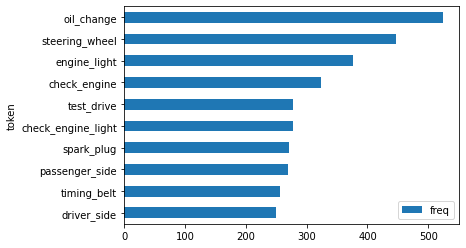

In [433]:
count_words(df, 'noun_phrases').head(10).plot(kind='barh').invert_yaxis()

In [456]:
df[nlp_columns] = df[nlp_columns].applymap(lambda items: ' '.join(items))
con = sqlite3.connect(BASE_PATH/db_name)
df.to_sql("posts_nlp", con, index=False, if_exists="replace")
con.close()